In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from behav_analysis import Data_Functions, Participant_Behav

def c_to_f(temp):
    """Convert celsius to fahrenheit"""
    
    return round(temp * 9/5 + 32, 2)

def get_exp_ts(df, exp_name):
    df_new = df[df["exp_name"] == exp_name]
    start_ts = df_new["start_timestamp"].item()
    end_ts = df_new["end_timestamp"].item()

    return start_ts, end_ts

def get_exp_dt(df, exp_name):
    df_new = df[df["exp_name"] == exp_name]
    start_dt = datetime.datetime.fromtimestamp(df_new["start_timestamp"].item()/1e9)
    end_dt = datetime.datetime.fromtimestamp(df_new["end_timestamp"].item()/1e9)

    return start_dt, end_dt

def get_start_index(df, start_dt):
    for loc, dt in enumerate(df["datetime"]):
        if not dt < start_dt:
            watch_start_dt = dt
            break

    return loc

def get_end_index(df, end_dt):
    for loc, dt in enumerate(df["datetime"]):  
        # NOTE: when slicing DataFrame, ending index is non-inclusive -> use exact loc value 
        if dt > end_dt:
            watch_end_dt = dt
            break

    return loc
    
class Participant_Watch():
    def __init__(self, par_num):
        self.par_num = par_num
        self.par_ID = f"participant_{self.par_num}"
        self.par_dir = os.path.join(os.getcwd(), "participants", self.par_ID)
        self.par_behav = Participant_Behav(par_num=self.par_num)
        self.exp_order = self.par_behav.exp_order
        self._dir_list = self._get_data_dirs()
        self.modalities = ["ACC", "BVP", "EDA", "HR", "TEMP"]
        self.modality_df_dict = self._create_modality_df_dict()
        self.marker_ts_df = self._create_marker_ts_df()
        self.exp_modality_data_dict = self._create_exp_modality_dict()

    def _get_data_dirs(self):
        watch_dir = os.path.join(self.par_dir, "watch_data")
        dir_list = []
        for dir_name in os.listdir(watch_dir):
            dir_list.append(os.path.join(watch_dir, dir_name))

        return dir_list

    def _modality_df(self, modality):
        df = pd.DataFrame()
        for i, watch_dir in enumerate(self._dir_list):
            filepath = os.path.join(watch_dir, modality + ".csv")
            temp_df = pd.read_csv(filepath)
            
            initial_ts = int(float(temp_df.columns[0]))
            samp_freq = int(temp_df.iloc[0][0])
            ts_col = pd.Series([initial_ts + i/samp_freq for i in range(temp_df.size)])
            dt_col = pd.Series([datetime.datetime.fromtimestamp(ts) for ts in ts_col])
            temp_df = temp_df[1:]
            temp_df.insert(loc=0, column="timestamps", value=ts_col)
            temp_df.insert(loc=1, column="datetime", value=dt_col)

            if modality == "ACC":
                temp_df.rename(columns={temp_df.columns[2]: "accel_x", temp_df.columns[3]: "accel_y", temp_df.columns[4]: "accel_z"}, inplace=True)
                temp_df["accel_x"] = temp_df["accel_x"]/64
                temp_df["accel_y"] = temp_df["accel_y"]/64
                temp_df["accel_z"] = temp_df["accel_z"]/64
            elif modality == "BVP" or modality == "EDA" or modality == "HR":
                temp_df.rename(columns={temp_df.columns[2]: modality}, inplace=True)    
            elif modality == "IBI":
                pass
            elif modality == "TEMP":
                temp_df.rename(columns={temp_df.columns[2]: "TEMP_C"}, inplace=True)
                temp_F_col = pd.Series([c_to_f(temp_C) for temp_C in temp_df["TEMP_C"]])
                temp_df.insert(loc=3, column="TEMP_F", value=temp_F_col)
            df = df.append(temp_df)
            df.reset_index(inplace=True, drop=True)

        return df

    def _create_modality_df_dict(self):
        modality_df_dict = {}
        for modality in self.modalities:
            modality_df_dict[modality] = self._modality_df(modality)
        
        return modality_df_dict

    def _create_marker_ts_df(self):
        data_fun = Data_Functions()
        marker_ts_filepath = os.path.join(self.par_dir, f"{self.par_ID}_marker_timestamps.csv")
        
        return data_fun.csv_to_df(marker_ts_filepath)

    def _create_exp_modality_dict(self):
        exp_modality_dict = {}
        for exp_name in self.exp_order:
            start_dt, end_dt = get_exp_dt(self.marker_ts_df, exp_name=exp_name)
            exp_modality_data_dict = {} 
            for modality, df in self.modality_df_dict.items():
                start_idx = get_start_index(df=self.modality_df_dict["TEMP"], start_dt=start_dt)
                end_idx = get_end_index(df=self.modality_df_dict["TEMP"], end_dt=end_dt)
                modality_data = self.modality_df_dict[modality].iloc[start_idx:end_idx]
                exp_modality_data_dict[modality] = modality_data
            exp_modality_dict[exp_name] = exp_modality_data_dict

        return exp_modality_data_dict

    def _plot_exp_regions(self, ax):
        for exp_name in self.exp_order:
            start_dt, end_dt = get_exp_dt(self.marker_ts_df, exp_name=exp_name)
            ax.axvline(start_dt, linestyle="dashed", color="k", alpha=0.75)
            ax.axvline(end_dt, linestyle="dashed", color="k", alpha=0.75)
            if exp_name == "audio_narrative":
                ax.axvspan(start_dt, end_dt, color="yellow", alpha=0.4, label="Audio Narrative")
            elif exp_name == "go_no_go":
                ax.axvspan(start_dt, end_dt, color="green", alpha=0.4, label="Go//No-Go")
            elif exp_name == "king_devick":
                ax.axvspan(start_dt, end_dt, color="blue", alpha=0.4, label="King Devick")
            elif exp_name == "n_back":
                ax.axvspan(start_dt, end_dt, color="purple", alpha=0.4, label="N-back")
            elif exp_name == "resting_state":
                ax.axvspan(start_dt, end_dt, color="pink", alpha=0.4, label="Resting State")
            elif exp_name == "tower_of_london":
                ax.axvspan(start_dt, end_dt, color="orange", alpha=0.4, label="Tower of London")
            elif exp_name == "video_narrative_cmiyc":
                ax.axvspan(start_dt, end_dt, color="red", alpha=0.4, label="Video Narrative CMIYC")
            elif exp_name == "video_narrative_sherlock":
                ax.axvspan(start_dt, end_dt, color="olive", alpha=0.4, label="Video Narrative Sherlock")
            elif exp_name == "vSAT":
                ax.axvspan(start_dt, end_dt, color="cyan", alpha=0.4, label="vSAT")

    def plot_modality(self, modality):
        datetime_fmt = mdates.DateFormatter('%H:%M:%S')
        modality_df = self.modality_df_dict[modality]

        fig, ax = plt.subplots(1, 1, figsize=(15, 6))
        
        if modality == "ACC":
            ax.plot(modality_df["datetime"], modality_df["accel_x"])
            ax.plot(modality_df["datetime"], modality_df["accel_y"])
            ax.plot(modality_df["datetime"], modality_df["accel_z"])
            ax.set_ylabel("Acceleration (g)", fontsize=16, color="k")
            ax.set_title("Acceleration", fontsize=20, color="k")
        elif modality == "BVP":
            ax.plot(modality_df["datetime"], modality_df["BVP"], color="k")
            ax.set_ylabel("BVP (???)", fontsize=16, color="k")
            ax.set_title("Photoplethysmograph", fontsize=20, color="k")
        elif modality == "EDA":
            ax.plot(modality_df["datetime"], modality_df["EDA"], color="k")
            ax.set_ylabel("EDA (μS)", fontsize=16, color="k")
            ax.set_title("Electrodermal", fontsize=20, color="k")
        elif modality == "HR":
            ax.plot(modality_df["datetime"], modality_df["HR"], color="k")
            ax.set_ylabel("Heart Rate (BPM)", fontsize=16, color="k")
            ax.set_title("Heart Rate", fontsize=20, color="k")
        elif modality == "TEMP":
            ax.plot(modality_df["datetime"], modality_df["TEMP_F"], color="k")
            ax.set_ylabel("Temperature (F)", fontsize=16, color="k")
            ax.set_title("Temperature", fontsize=20, color="k")

        ax.set_xlabel("Time", fontsize=16, color="k")
        ax.xaxis.set_major_formatter(datetime_fmt)
        self._plot_exp_regions(ax=ax)
        ax.legend(bbox_to_anchor=(1.0, 0.75), facecolor='white', framealpha=1)

In [2]:
par_num = "03"
par = Participant_Watch(par_num=par_num)

c:\Users\zackg\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


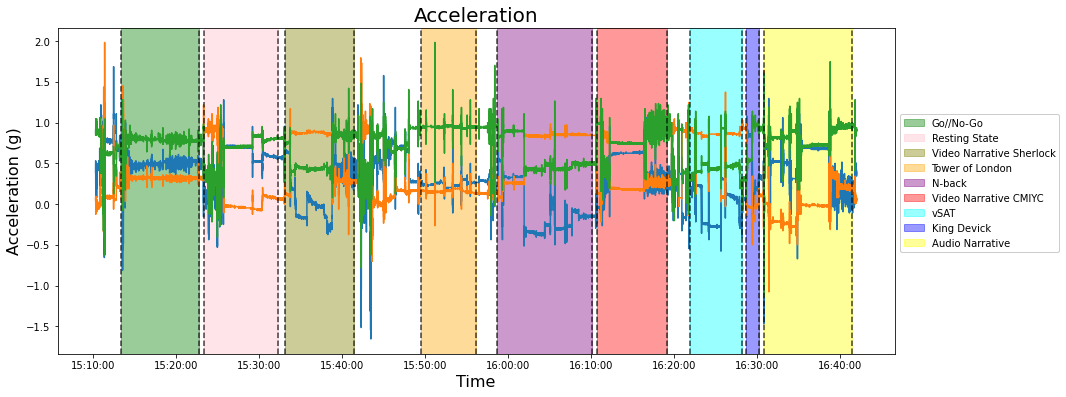

In [3]:
### Accelerometer ###
par.plot_modality("ACC")

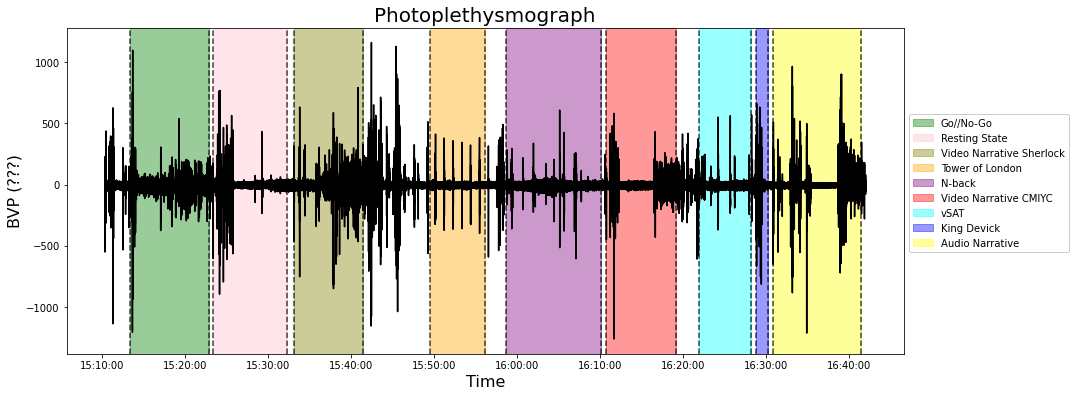

In [4]:
### Photoplethysmograph ###
par.plot_modality("BVP")

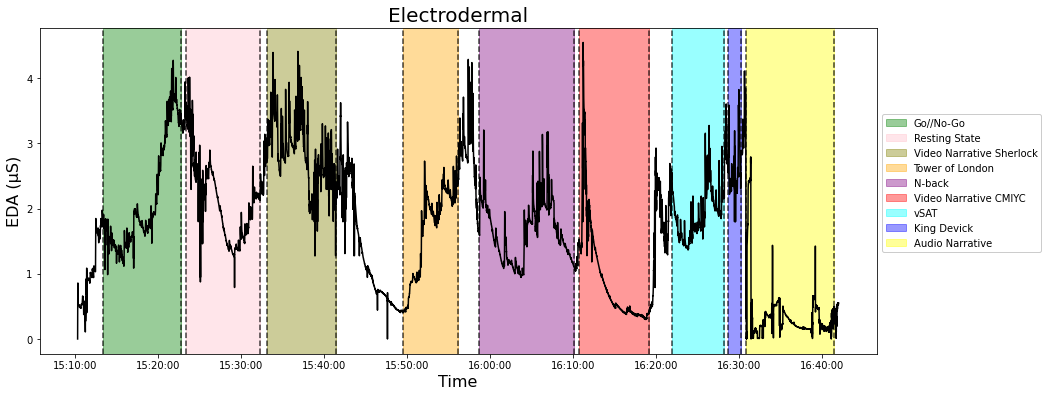

In [5]:
### Electrodermal ###
par.plot_modality("EDA")

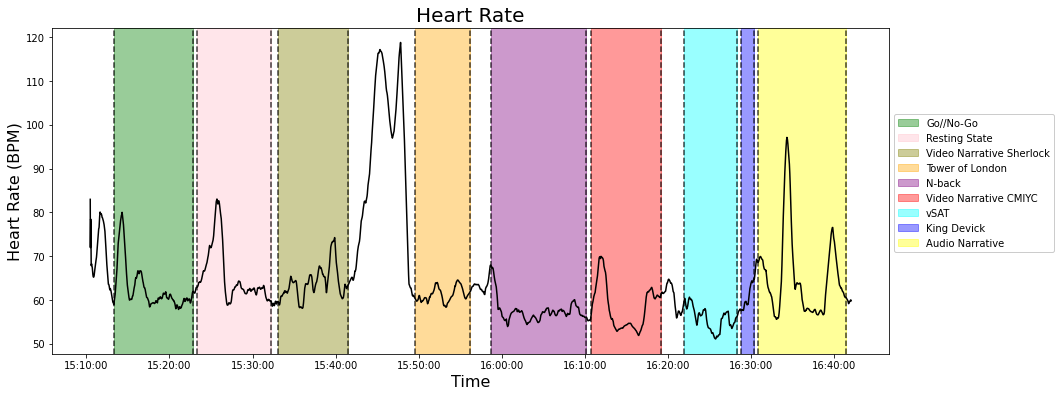

In [6]:
### Heart Rate ###
par.plot_modality("HR")

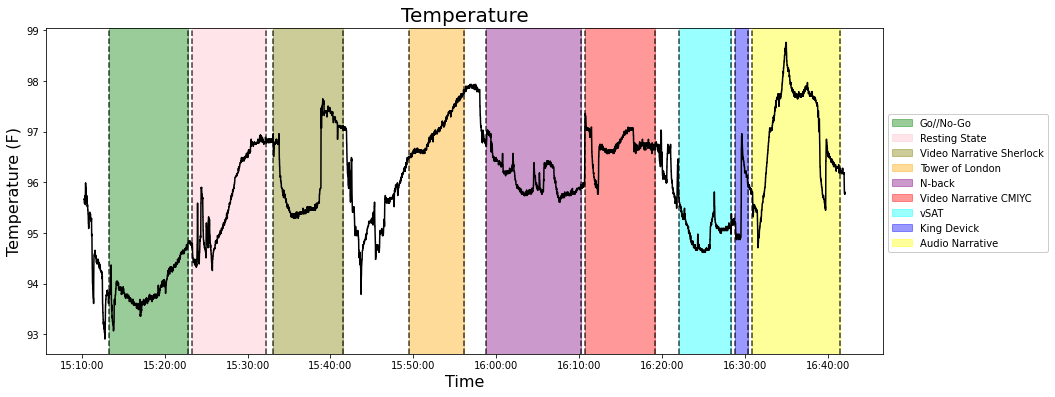

In [7]:
### Temperature ###
par.plot_modality("TEMP")